In [1]:
#   bem: triangulation and fmm/bem electrostatics tools 
#
#   Copyright (C) 2011-2012 Robert Jordens <jordens@gmail.com>
#
#   This program is free software: you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation, either version 3 of the License, or
#   (at your option) any later version.
#
#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.
#
#   You should have received a copy of the GNU General Public License
#   along with this program.  If not, see <http://www.gnu.org/licenses/>.

# `bem` 3D electrostatics example

In [10]:
import sys
import logging, os
import numpy as np
# To import pyface.py is just for setting "Qt" sip API version to 2 before matplotlib sets it to default v1 
# that is incompatible with "pyside" in package "mayavi". wwc
import pyface.qt    
import matplotlib.pyplot as plt
from multiprocessing import Pool    # parallel computation.

sys.path.append('../../')   # add path of package "bem" to search list. wwc
sys.path.append('../../../electrode/')   # add path of package "electrode" to search list. wwc

from bem import Electrodes, Sphere, Mesh, Grid, Configuration, Result
from bem.formats import stl

In [11]:
# base file name for outputs and inputs is the script name
try:
    # works only if we are a script
    prefix = os.path.splitext(__file__)[0]
except NameError:
    # fallback for notebooks
    prefix = "SE_cos_m8"
suffix = ""

In [12]:
### scale to natural units (ion height)
scale = 40e-6    # 40 um: from ion to electrode.
use_stl = True

if not use_stl:
    # load electrode faces from loops
    ele = Electrodes.from_trap(open("%s.ele" % prefix), scale)
    # initial triangulation, area 20, quiet
    mesh = Mesh.from_electrodes(ele)
    mesh.triangulate(opts="qa10Q")
else:
    # load electrode faces from colored stl
    # s_nta is binary stl file after processing, will explain in next cell. wwc
    s_nta = stl.read_stl(open("%s.stl" % prefix, "rb"))
    print "Import stl:", os.path.abspath("./"+prefix+".stl"),"\n"
    # At first you don't know the coded numbers of electorde colors, just randomly specify rename argument 
    # like this, and stl.stl_to_mesh() will drop the numbers for you in the output. wwc 
    # stl_to_mesh() only assigns names and does scaling, it does nothing to stl mesh.  wwc
    print "Electrode colors (numbers):\n"
    mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=scale/1e-6,rename={1:"DC1"}))    

Import stl: /home/wwc/bem_git/bem/examples/SimpleTrap/SE_cos_m8.stl 

Electrode colors (numbers):

dropping 24311
dropping 28165
dropping 0
dropping 1882
dropping 8456
dropping 1530
dropping 1633
dropping 24


In [17]:
print len(s_nta), type(s_nta), "\n"    # s_nta is a length 3 tuple. wwc
# normal, triangle, attribute wwc
# normal direction of each triangle, three vetice of triangles, coded color numbers wwc
# print s_nta[0], s_nta[1], s_nta[2], "\n"
print "Triangles:",len(s_nta[0]),"\n", "Colors:",len(s_nta[2]),"\n"    # This isn't right.  wwc

# Use the color numbers to give each electrode a name after the first try. wwc"
# Won't print any non-zero number now. wwc
# 1e-6 is in the unit of um.
mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=scale/1e-6,#ename={1882:"DC2",1633:"DC3",28165:"DC5",30653:"RF",24603:"DC1"}))
                                                                       #1530:"DC1",1882:"DC4",30653:"RF"}))
    rename={0:"DC1",28165:"DC2",1882:"DC3",1530:"DC4",1633:"DC5",8456:"DC6",24:"RF"}))    
    # 0:Black, 24:Red, 24311:Default, 1633:Dark Green, 30653:White, 28165:Cyran, 1882:Yello, 1530:Orange  wwc

3 <type 'tuple'> 

Triangles: 764 
Colors: 764 

dropping 24311


Output vtk: /home/wwc/bem_git/bem/examples/SimpleTrap/SE_cos_m8.vtk


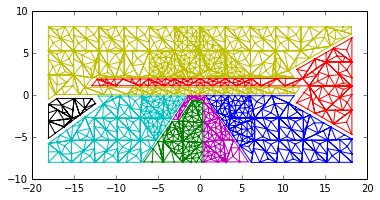

In [18]:
# set .1 max area within 3
# This cell draws triangle meshes. wwc
# areas_from_constraints specifies a region with finer mesh. wwc
mesh.areas_from_constraints(Sphere(center=np.array([0, 0, 1.]),    # Finer mesh inside sphere. wwc
           radius=6, inside=0.3, outside=1.2))    # "inside", "outside" assign different mesh densities. wwc
# retriangulate quality and quiet with areas
mesh.triangulate(opts="qQ", new=False)
# save base mesh to vtk
mesh.to_vtk(prefix+suffix)
print "Output vtk:",os.path.abspath("./"+prefix+suffix+".vtk")    # path of output  wwc

# Plot the mesh. Finer mesh at center is caused by above "Sphere". wwc
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
mesh.plot(ax)

In [19]:
# Define a function for computation. wwc
def run_job(args):
    # job is Configuration instance.  wwc
    job, grid, prefix = args
    # refine twice adaptively with increasing number of triangles, min
    # angle 25deg
    job.adapt_mesh(triangles=4e2, opts="q25Q")
    job.adapt_mesh(triangles=1e3, opts="q25Q")
    # solve for charges
    # The general path is, 1. Iteratively solve charge distribution until it's consistent with 
    # one electrode at 1V and others at 0V. wwc
    job.solve_singularities(num_lev=3)
    # get potentials and fields
    # 2. Potentials on grid points are calculated by Configuration.simulate, 
    # based on charge distributions previously gotten. wwc
    # (For RF the method is different from DC? num_lev=1 specifies its fastlap mode. See README.rst.) wwc
    result = job.simulate(grid, field=job.name=="RF", num_lev=1)    # For "RF", field=True so it computes the field. wwc
    result.to_vtk(prefix)
    print "finished job %s" % job.name
    return job.collect_charges()

In [20]:
# grid to evalute potential and fields at
n, s = 2*60, 0.05  
Lx, Ly, Lz = 3, 3, 3        # um
sx, sy, sz = s, s, s                        # pay attention to "s/2. not "s/2", we are in python 2. wwc
# n is the grid point number, s is step length. So to fix size on i direction you need to fix ni*si. wwc
nx, ny, nz = [2*(int(L/2.0/s)+1) for L in (Lx, Ly, Lz)]
print "Size(um)", Lx, Ly, Lz
print "Step", sx, sy, sz
print "Shape (grid point numbers)", nx, ny, nz
# center: (nx, ny ,nz)/2 shifts to center (so n must be even). shape: the computation region. wwc
grid = Grid(center=(0, 1, 1), step=(sx, sy, sz), shape=(nx, ny, nz)) 

Size(um) 3 3 3
Step 0.05 0.05 0.05
Shape (grid point numbers) 62 62 62


In [21]:
# generate electrode potential configurations to simulate
# use regexps to match electrode names
jobs = list(Configuration.select(mesh, "DC.*","RF"))    # select() is to pick one electrode each time. wwc
# run the different electrodes on the parallel pool
#pmap = Pool().map # parallel map
pmap = map # serial map
pmap(run_job, ((job, grid, prefix+suffix) for job in jobs))
# run_job will cast a word after finishing each electrode. wwc

finished job DC2
finished job DC1
finished job DC3
finished job DC6
finished job DC4
finished job DC5
finished job RF


[array([ 6.92506525, -1.53737184, -1.50230279, -0.02059369, -0.23066963,
        -0.16986559, -1.95568674]),
 array([-1.53815476, 10.63606169, -0.11091765, -0.03351027, -0.09241115,
        -0.32105963, -7.34740676]),
 array([-1.4412407 , -0.11054556,  4.46688902, -0.00942221, -1.58914867,
        -0.43368572, -0.50592525]),
 array([-0.02142242, -0.03464597, -0.00969389,  2.26791395, -0.01959178,
        -0.98971803, -0.83934869]),
 array([-0.23170478, -0.09186468, -1.63311701, -0.01931602,  3.96202001,
        -1.16368338, -0.33775594]),
 array([-0.16969657, -0.32183043, -0.450543  , -0.87339236, -1.20164092,
         6.62615698, -2.20961626]),
 array([-1.89029094, -7.21830074, -0.49908712, -0.72750704, -0.33465025,
        -2.11969289, 16.58478051])]

yz plane, RF pseudo


/home/wwc/anaconda3/envs/bem27/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/wwc/anaconda3/envs/bem27/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


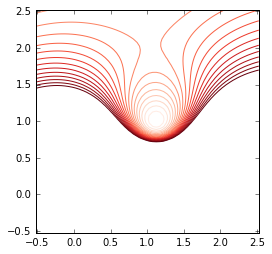

In [9]:
# isocontour plot of the RF pseudopotential radially
result = Result.from_vtk(prefix+suffix, "RF")
p = result.pseudo_potential    # pseudo_potential
x = grid.to_mgrid()[:, p.shape[0]/2]    # p.shape[0]/2 is at the middle of x. wwc
p = p[p.shape[0]/2]    # get the slice of yz plane at x = p.shape[0]/2, the middle plane. wwc
print "yz plane, RF pseudo"
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 2e-2, 20), cmap=plt.cm.Reds)

In [18]:
result = Result.from_vtk(prefix+suffix, "DC1")
x = grid.to_mgrid()[:, p.shape[0]/2]
p = result.potential    # pseudo_potential
print x
p.shape

[[[ 0.025  0.025  0.025 ...  0.025  0.025  0.025]
  [ 0.025  0.025  0.025 ...  0.025  0.025  0.025]
  [ 0.025  0.025  0.025 ...  0.025  0.025  0.025]
  ...
  [ 0.025  0.025  0.025 ...  0.025  0.025  0.025]
  [ 0.025  0.025  0.025 ...  0.025  0.025  0.025]
  [ 0.025  0.025  0.025 ...  0.025  0.025  0.025]]

 [[-0.525 -0.525 -0.525 ... -0.525 -0.525 -0.525]
  [-0.475 -0.475 -0.475 ... -0.475 -0.475 -0.475]
  [-0.425 -0.425 -0.425 ... -0.425 -0.425 -0.425]
  ...
  [ 2.425  2.425  2.425 ...  2.425  2.425  2.425]
  [ 2.475  2.475  2.475 ...  2.475  2.475  2.475]
  [ 2.525  2.525  2.525 ...  2.525  2.525  2.525]]

 [[-1.525 -1.475 -1.425 ...  1.425  1.475  1.525]
  [-1.525 -1.475 -1.425 ...  1.425  1.475  1.525]
  [-1.525 -1.475 -1.425 ...  1.425  1.475  1.525]
  ...
  [-1.525 -1.475 -1.425 ...  1.425  1.475  1.525]
  [-1.525 -1.475 -1.425 ...  1.425  1.475  1.525]
  [-1.525 -1.475 -1.425 ...  1.425  1.475  1.525]]]


(62, 62, 62)

p max 4077.1726000000003
yz plane, superposition


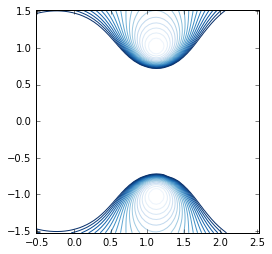

In [12]:
# isocontour plot of the DC potential
resultf = Result.from_vtk(prefix+suffix, "RF")
result1 = Result.from_vtk(prefix+suffix, "DC1")
result2 = Result.from_vtk(prefix+suffix, "DC4")
result3 = Result.from_vtk(prefix+suffix, "DC5")
pf = resultf.pseudo_potential
pdc = [result1.potential, result2.potential, result3.potential]
sf = 103.25
sdc = [0,0,0]
p = sf*pf
for it in range(len(sdc)):
    p += sdc[it]*pdc[it]
maxp = np.amax(p)
print "p max", maxp
x = grid.to_mgrid()[:,p.shape[0]/2]
p = p[p.shape[0]/2]
print "yz plane, superposition"
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 2, 20), cmap=plt.cm.Blues)

p max 8718.522737320001
xz plane, superposition


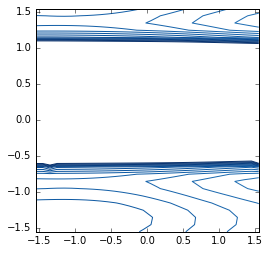

In [35]:
# isocontour plot of the DC potential
resultf = Result.from_vtk(prefix+suffix, "RF")
result1 = Result.from_vtk(prefix+suffix, "DC1")
result2 = Result.from_vtk(prefix+suffix, "DC4")
result3 = Result.from_vtk(prefix+suffix, "DC5")
pf = resultf.pseudo_potential
pdc = [result1.potential, result2.potential, result3.potential]
sf = 50.
sdc = [5,5,1]
p = sf*pf
for it in range(len(sdc)):
    p += sdc[it]*pdc[it]
maxp = np.amax(p)
print "p max", maxp
x = grid.to_mgrid()[:,:,p.shape[1]/2]
p = p[:,p.shape[1]/2]
print "xz plane, superposition"
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[0], x[2], p, levels=np.linspace(0, 2, 50), cmap=plt.cm.Blues)

p max 174.282
xy plane, RF pseudo


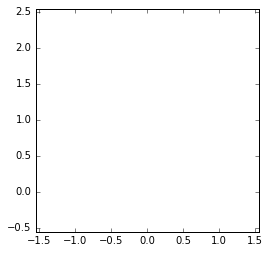

In [42]:
# isocontour plot of the RF pseudopotential radially wwc
result = Result.from_vtk(prefix+suffix, "RF")
p = result.pseudo_potential
maxp = np.amax(p)
print "p max", maxp
coord = grid.to_mgrid()
x = coord[:,:,:,p.shape[2]/2]
p = p[:,:,p.shape[2]/2]
print "xy plane, RF pseudo"
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[0], x[1], p, levels=np.linspace(0, maxp, 50), cmap=plt.cm.Reds)

p max 1.01357
xy plane


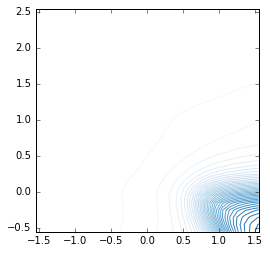

In [38]:
# isocontour plot of the DC potential
result = Result.from_vtk(prefix+suffix, "DC2")
praw = result.potential
maxp = np.amax(praw)    # Want to know if an electrode is set 1V. wwc
print "p max", maxp
coord = grid.to_mgrid()    # coord is a special coordinate structure which is prepared for plt.contour(). wwc
x = coord[:,:,:,praw.shape[2]/2]    # ?
p = praw[:,:,praw.shape[2]/2]    # praw.shape[2]/2 gets the middle xy plane along z. wwc 
print "xy plane"
fig, ax = plt.subplots()
ax.set_aspect("equal")
# xy plane should use x[0] and x[1]. levels=[start, end, number] of potential lines. wwc
ax.contour(x[0], x[1], p, levels=np.linspace(0, maxp, 50), cmap=plt.cm.Blues) 

In [16]:
print coord.shape    # coord.shape is a tuple that stores the length of x, y, z, respectively. wwc
print coord[:,praw.shape[0]/2].shape    # plane at nx/2 wwc 
print praw.shape
coord

(3, 32, 32, 32)
(3, 32, 32)
(32, 32, 32)


array([[[[-1.55, -1.55, -1.55, ..., -1.55, -1.55, -1.55],
         [-1.55, -1.55, -1.55, ..., -1.55, -1.55, -1.55],
         [-1.55, -1.55, -1.55, ..., -1.55, -1.55, -1.55],
         ...,
         [-1.55, -1.55, -1.55, ..., -1.55, -1.55, -1.55],
         [-1.55, -1.55, -1.55, ..., -1.55, -1.55, -1.55],
         [-1.55, -1.55, -1.55, ..., -1.55, -1.55, -1.55]],

        [[-1.45, -1.45, -1.45, ..., -1.45, -1.45, -1.45],
         [-1.45, -1.45, -1.45, ..., -1.45, -1.45, -1.45],
         [-1.45, -1.45, -1.45, ..., -1.45, -1.45, -1.45],
         ...,
         [-1.45, -1.45, -1.45, ..., -1.45, -1.45, -1.45],
         [-1.45, -1.45, -1.45, ..., -1.45, -1.45, -1.45],
         [-1.45, -1.45, -1.45, ..., -1.45, -1.45, -1.45]],

        [[-1.35, -1.35, -1.35, ..., -1.35, -1.35, -1.35],
         [-1.35, -1.35, -1.35, ..., -1.35, -1.35, -1.35],
         [-1.35, -1.35, -1.35, ..., -1.35, -1.35, -1.35],
         ...,
         [-1.35, -1.35, -1.35, ..., -1.35, -1.35, -1.35],
         [-1.35, -1.35, -1

In [17]:
# To see the symmetry of potential distribution (and then know axes.). wwc
print "x axis"
print(praw[0,ny/2-1,nz/2-1], praw[nx-1,ny/2-1,nz/2-1])
print(praw[0+10,ny/2-1,nz/2-1], praw[nx-1-10,ny/2-1,nz/2-1])  # x

print "y axis"
print(praw[nx/2-1,0,nz/2-1], praw[nx/2-1,ny-1,nz/2-1])
print(praw[nx/2-1,0+10,nz/2-1], praw[nx/2-1,ny-1-10,nz/2-1])  # y

print "z axis"
print(praw[nx/2-1,ny/2-1,0], praw[nx/2-1,ny/2-1,nz-1])
print(praw[nx/2-1,ny/2-1,0+5], praw[nx/2-1,ny/2-1,nz-1-5])  # z

x axis
(0.0031446, 0.0209196)
(0.00518431, 0.0118302)
y axis
(0.00799479, 0.00160611)
(0.00599589, 0.00291674)
z axis
(0.0809853, 0.0809853)
(0.0658036, 0.0658036)


p max 1.93439516
xy plane, superposition


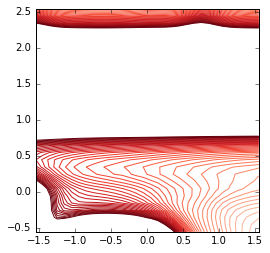

In [39]:
# isocontour plot of the DC potential
result0 = Result.from_vtk(prefix+suffix, "RF")
result1 = Result.from_vtk(prefix+suffix, "DC1")
result2 = Result.from_vtk(prefix+suffix, "DC4")
result3 = Result.from_vtk(prefix+suffix, "DC5")
p0 = result0.pseudo_potential
p1, p2, p3 = result1.potential, result2.potential, result3.potential
strength = np.amax(p1)/np.amax(p0)    # This is a factor ratio between DC and RF electrode. wwc
p = strength*p0+p1+p2+p3    # *strength to see RF clearly. wwc
maxp = np.amax(p)
print "p max", maxp
x = grid.to_mgrid()[:,:,:,p.shape[2]/2]
p = p[:,:,p.shape[2]/2]
print "xy plane, superposition"
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[0], x[1], p, levels=np.linspace(0, 2e-1, 50), cmap=plt.cm.Reds)

p max 0.262108
yz plane


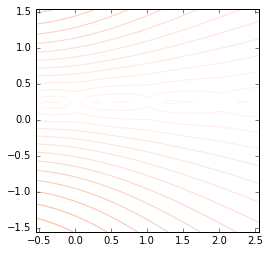

In [40]:
# isocontour plot of the DC potential
result = Result.from_vtk(prefix+suffix, "DC5")
p = result.potential
maxp = np.amax(p)
print "p max", maxp
x = grid.to_mgrid()[:,p.shape[0]/2]    # ~ :,p.shape[0]/2,:,:  at nx/2. wwc
p = p[p.shape[0]/2]
print "yz plane"
fig, ax = plt.subplots()
ax.set_aspect("equal")
# yz plane should use x[1], x[2]. wwc
ax.contour(x[1], x[2], p, levels=np.linspace(0, maxp, 50), cmap=plt.cm.Reds)    # 2e-2

p max 1.04684
yz plane


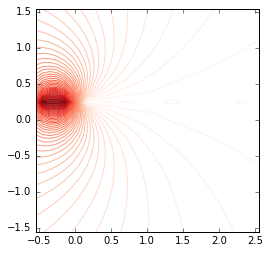

In [41]:
# isocontour plot of the DC potential
result = Result.from_vtk(prefix+suffix, "DC3")
p = result.potential
maxp = np.amax(p)
print "p max", maxp
x = grid.to_mgrid()[:,p.shape[0]/2]
p = p[p.shape[0]/2]
print "yz plane"
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, maxp, 50), cmap=plt.cm.Reds)

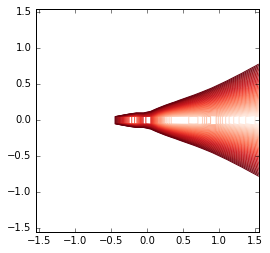

In [21]:
# isocontour plot of the DC potential
result = Result.from_vtk(prefix+suffix, "DC3")
p = result.potential
x = grid.to_mgrid()[:,p.shape[0]/2]
p = p[p.shape[0]/2]
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 2e-2, 50), cmap=plt.cm.Reds)
# Different start and end values make a big difference. wwc

In [22]:
# explore it in fancy 3D
# fire up a mayavi2 window showing base mesh, charges on final mesh
# and isosurfaces of the pseudopotential
Result.view(prefix+suffix, "RF")
# need to start the full eventloop for the window.
# close it to return control to the notebook
from pyface.api import GUI
GUI().start_event_loop()

# Seems that can't lauch gui through X11 remote and caused dead kernel. wwc

In [23]:
r = Result.from_vtk(prefix+suffix, "DC1")
print type(r)
print r.configuration
print r.field
print r.pseudo_potential
print r.potential.shape, type(r.potential)

<class 'bem.electrostatics.Result'>
None
None
None
(32, 32, 32) <type 'numpy.ndarray'>


In [24]:
# r = Result.from_vtk(prefix+suffix, "RF")
# print type(r)
# print r.configuration
# print r.field    # [Ex,Ey, Ez], x,y,z
# print r.pseudo_potential
# print r.potential.shape, type(r.potential)
# print r.potential

In [25]:
# electrode is an another package in nist-ionstorage github. wwc
from electrode import System, GridElectrode

# load the electrostatics results into a electrode.System()
s = System()
for name in "DC1".split():    # DC2 DC3 DC4 DC5 RF
    r = Result.from_vtk(prefix+suffix, name)
    e = GridElectrode.from_result(r,maxderiv=0)
    e.name = name
    s.append(e)
# s["RF"].rf = 1.

In [26]:
print type(e.data)
print e.origin, e.spacing
print len(e.data),e.data[0].shape
e.data

<type 'list'>
[-1.55 -1.55 -1.55] [0.1 0.1 0.1]
1 (32, 32, 32, 1)


[array([[[[0.0534857],
          [0.0509823],
          [0.0483396],
          ...,
          [0.0483396],
          [0.0509823],
          [0.0534857]],
 
         [[0.052954 ],
          [0.050475 ],
          [0.0478584],
          ...,
          [0.0478584],
          [0.050475 ],
          [0.052954 ]],
 
         [[0.0523867],
          [0.0499323],
          [0.0473424],
          ...,
          [0.0473424],
          [0.0499323],
          [0.0523867]],
 
         ...,
 
         [[0.0317912],
          [0.0300468],
          [0.0282518],
          ...,
          [0.0282518],
          [0.0300468],
          [0.0317912]],
 
         [[0.0311385],
          [0.0294201],
          [0.0276532],
          ...,
          [0.0276532],
          [0.0294201],
          [0.0311385]],
 
         [[0.0305058],
          [0.028813 ],
          [0.0270737],
          ...,
          [0.0270737],
          [0.028813 ],
          [0.0305058]]],
 
 
        [[[0.0559467],
          [0.0533914],

In [27]:
from scipy.constants import atomic_mass
x0 = s.minimum((0, 0, 1.))
for _ in s.analyze_static(x0, m=25*atomic_mass, #u=50.,      # u is V rf peak voltage, but it causes error.
                          l=40e-6, o=100e6*2*np.pi):
    print _

parameters:
 f=100 MHz, m=25 amu, q=1 qe, l=40 µm, scale=0.0391 V'/V_SI
coordinates:
 analyze point: [0. 0. 1.]
               ([ 0.  0. 40.] µm)
 minimum is at offset: [0. 0. 0.]
                      ([0. 0. 0.] µm)
potential:
 dc electrical: 0 eV
 rf pseudo: 0 eV
 saddle offset: [nan nan nan]
               ([nan nan nan] µm)
 saddle height: 0 eV
force:
 dc electrical: [0. 0. 0.] eV/l
               ([0. 0. 0.] eV/m)
 rf pseudo: [0. 0. 0.] eV/l
           ([0. 0. 0.] eV/m)
modes:
 pp+dc normal curvatures: [0. 0. 0.]
 motion is bounded: True
 pseudopotential modes:
  a: 0 MHz, [1. 0. 0.]
  b: 0 MHz, [0. 1. 0.]
  c: 0 MHz, [0. 0. 1.]


../../../electrode/electrode/saddle.py:77: RuntimeWarning: invalid value encountered in true_divide
  dx = -v*np.matrix(gl/lmg).T


ValueError: invalid axes sequence

In [ ]:
n = 30
#xyz = np.mgrid[-.1:.1:1j*n, -.1:.1:1j*n, 1.12:2]
#xyz = np.mgrid[0:1, -.02:.02:1j*n, .5:1.5:1j*n]
xyz = grid.to_mgrid()
p = s.potential(xyz.reshape(3, -1).T, 0).reshape(xyz[0].shape)
v = np.linspace(0, 2e-2, 21)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(xyz[1, 10, :, :], xyz[2, 10, :, :], p[10, :, :], v, cmap=plt.cm.Reds_r)